# Trabalho Prático Aprendizagem Automática


In [4]:
import re, pickle, time, datetime
from tempfile import TemporaryDirectory

from sklearn.svm import LinearSVC,SVC

import numpy as np

from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.datasets import load_files
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import cross_val_score , GridSearchCV , RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.pipeline import Pipeline


from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
#Possiveis de serem usadas : numpy, scipy, matplotlib, sklearn, nltk, re e opencv 

Carregar os ficheiros

In [5]:
with open('imdbCriticas.p', 'rb') as f:
    global D, Docs, y
    D = pickle.load(f)
    Docs = D.data
    y = D.target

with open('tfidf_dump.p', 'rb') as f:
    global tfidf
    tfidf = pickle.load(f)

In [3]:
y.shape

(40000,)

Podemos analisar a quantidade de reviews de cada uma das possíveis reviews

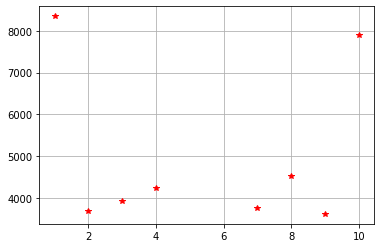

In [8]:
rating, value=np.unique(y,return_counts=True)
plt.plot(rating,value,'*r')
plt.grid()

Usamos este metodo para préprocessar os dados de texto, e reduzir as palavras tendo em conta os erros de ortografia

O stemmer por defeito é o lancaster, porque teve os melhores resultados e se o argumento não corresponder a nenhum outro, este é utilizado

In [6]:
def preProcessDoc(Doc, stemmer = 'lancaster', decode = False):
    stem = {
        'porter'   : PorterStemmer(),
        'snowball' : SnowballStemmer('english'),
        'lancaster': LancasterStemmer()
    }
    stemFunc = stem.get(stemmer, LancasterStemmer())
    if(decode):
        Doc = Doc.decode('UTF-8')
    Doc = Doc.replace('<br />', ' ')
    Doc = re.sub(r'[^a-zA-Z\u00C0\u00FF]+', ' ', Doc)
    Doc = ' '.join([stemFunc.stem(w) for w in Doc.split()])
    return Doc

def preProcessDocs(Docs, stemmer='lancaster', decode = False):
    return [preProcessDoc(doc, stemmer, decode) for doc in Docs]

def text2vector(Docs, preProcess = False, stemmer='lancaster', decode=False, targets=None, normalize=True):
    if(preProcess):
        Docs = preProcessDocs(Docs, stemmer=stemmer, decode=decode)
    
    global tfidf
    try:
        tfidf ## ver se tfidf já está definido
    except:
        tfidf = pickle.load(open('tfidf_dump.p','rb'))

        
    X = tfidf.transform(Docs)
    if not normalize:
        return X
    ##return Normalizer().fit_transform(X, targets)
    return X

## Classificação Binária

Converter da escala de 0 a 10, para negativos/positivos

In [7]:
y_boolean = [0 if val<5 else 1 for val in y]

### Steemers

O stemmer reduz uma palavra á sua raiz, ou seja, remove plurais, conjugacao de verbos, etc

#### Porter

In [7]:
X = preProcessDocs(Docs, stemmer='porter')
tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X)
dl = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf.get_feature_names()))
print(dl.score(vector, y_boolean))

Token len 26773
0.9455


#### Snowball

In [8]:
X = preProcessDocs(Docs, stemmer='snowball')
tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X)
dl = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf.get_feature_names()))
print(dl.score(vector, y_boolean))

Token len 26394
0.945375


#### Lancaster

In [9]:
X = preProcessDocs(Docs, stemmer='lancaster')
tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X)
dl = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf.get_feature_names()))
print(dl.score(vector, y_boolean))

Token len 21883
0.9394


In [10]:
print('P' ,26773/0.945525)
print('S' ,26394/0.94535)
print('L' ,21883/0.939425)

P 28315.486105602708
S 27919.818056804357
L 23294.036245575753


É possivel ver que o lancaster é o que reduz ao maximo a quantidade de tokens, alem disso vamos optar por utilizar o Lancaster pois precisava de uma quantidade de tokens menores para atingir os teoricos 100%

## Comparar modelos lineares

In [8]:
with open('docs_dump.p', 'rb') as f:
    X = pickle.load(f)

In [18]:
X = preProcessDocs(Docs)
with open('docs_dump.p', 'wb') as f:
    pickle.dump(X, f)

In [6]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    global pipeline, grid_param, grid_search
    
    pipeline =Pipeline([
        ('tfidf' , TfidfVectorizer()),
        ('clf' , LogisticRegressionCV(max_iter = 1000, tol=1e-3))
    ], memory=tmpdir)

    grid_param ={
        'tfidf__strip_accents' :[None, 'unicode'],
        #'tfidf__stop_words' : [None, 'english'],
        'tfidf__token_pattern' : [r'\b\w{3,}\b', r'\b[a-zA-Z]{3,}\b'],
        'tfidf__min_df' : np.arange(3, 5, 1),
        'tfidf__max_df' : [0.25, 0.5, 0.75],
        #'tfidf__min_df' : [3,4,5],
        #'tfidf__min_df' : [3],
        #'tfidf__ngram_range' : [(i,j) for i in range(1,5) for j in range(1,5)],
        'tfidf__ngram_range' : [(1,1), (1,2), (1,3) , (2,2)] ,
        'tfidf__norm' : ['l1', 'l2'],
        'tfidf__max_features' : [None, 15000,20000,25000,30000],

       


        #'clf__C' : np.linspace(0.1,10,100),
        'clf__Cs' : [1,3,10,30,100], 
        #'clf__C' : [3.3],
        'clf__solver' : ['sag', 'saga'],
        #'clf__tol' : (1e-3, 1e-4, 1e-5)
    }
    t0 =time.localtime()
    print('Started at'  , time.strftime("%H:%M:%S", t0))
    ## Se tiveres mais memoria que eu(8Gb), aumenta o pre_dispatch para um valor maior
    grid_search = RandomizedSearchCV(pipeline, grid_param, cv = 3, n_jobs=-1, verbose=3,\
                                     pre_dispatch=8,n_iter = 30).fit(X, y_boolean)

    t1 = time.localtime()
    print('Done at' , time.strftime("%H:%M:%S", t1))
with open('dump.p', 'wb') as f:
    pickle.dump({'in' : grid_param ,
                 'out': grid_search}, f)

Started at 15:16:13
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 56.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 28.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Done at 16:17:27


In [7]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
             print('\t' * (indent+1) + str(value))

pretty(grid_search.cv_results_, 0)

mean_fit_time
	[690.02867977  37.32141058 369.89045056 137.35754371 456.18932152
 184.8494792  236.27336701 402.69934948 289.6661249  756.45097788
 268.18874661 187.31101513  66.68613791 175.29305712  90.3015159 ]
std_fit_time
	[ 5.4261045   4.62307497 50.23601666  1.57604928  8.96949775  3.51713334
  4.20336944  3.99793306 11.44582785 18.09002713  7.72037476  1.22601322
  0.6180658   4.00822898 15.02676939]
mean_score_time
	[7.50773851 5.12932785 6.34752345 4.35355218 5.90589515 6.3094004
 4.53880405 6.44200897 3.91615399 5.21079381 9.53086813 6.47203175
 6.27580039 4.19172374 2.21245686]
std_score_time
	[0.21851615 0.71846843 0.46596361 0.10303288 0.20755637 0.20009386
 0.14472093 0.11510817 0.48230765 0.36749729 0.60210629 0.21899587
 0.3289914  0.46973708 0.67657892]
param_tfidf__token_pattern
	['\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b'
 '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b'
 '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b' '\\b\\w{3,}\\b' '\\

In [10]:
print(grid_search.best_index_)
print(grid_search.best_estimator_)

0
Pipeline(memory='C:\\Users\\pedro\\AppData\\Local\\Temp\\sklearn_graph_cache_mwl12peq',
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=None,
                                 min_df=4, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 st...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('norm', Normalizer(copy=True, norm='l1')),
                ('clf',
                 LogisticRegressionCV(Cs=3, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                            

## Em vez de correr o codigo em cima, podemos fazer import do ficheiro dump

In [21]:
with open('dump.p' ,'rb') as f:
    global grid_param, grid_search
    temp = pickle.load(f)
    grid_param = temp['in']
    grid_search = temp['out']
print(grid_search.best_estimator_)

Pipeline(memory='C:\\Users\\pedro\\AppData\\Local\\Temp\\sklearn_graph_cache_mwl12peq',
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=None,
                                 min_df=4, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 st...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('norm', Normalizer(copy=True, norm='l1')),
                ('clf',
                 LogisticRegressionCV(Cs=3, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                              

###  TFIDF optimizado

In [10]:
with open('tfidf_dump.p', 'wb') as f:
    tfidf = TfidfVectorizer(max_df=0.75 , min_df=4,ngram_range=(1, 2), norm='l2', token_pattern=r'\b\w{3,}\b',).fit(X)
    pickle.dump(tfidf, f)

In [11]:
len(tfidf.get_feature_names())

210238

### Classificacao booleana

In [9]:
vector = text2vector(X, targets=y_boolean)


In [ ]:
with open('vector_dump.p', 'wb') as f:
    pickle.dump(vector, f)

In [6]:
with open('vector_dump.p', 'rb') as f:
    vector = pickle.load(f)

In [16]:
##tfidf = TfidfVectorizer(min_df = 3, token_pattern=r'\b\w{3,}\b', norm = 'l2' , ngram_range=(1,2)).fit(Docs)
dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5, penalty='l2', solver='saga').fit(vector,y_boolean)
print(dl.score(vector, y_boolean))
print(dl.scores_)

1.0
{1: array([[0.50525 , 0.888   , 0.89675 ],
       [0.50525 , 0.893625, 0.90275 ],
       [0.50525 , 0.898875, 0.904875],
       [0.50525 , 0.903875, 0.913375],
       [0.50525 , 0.895625, 0.909125]])}


In [17]:
x_train, x_test, y_train, y_test = train_test_split(vector, y_boolean, test_size=1/4)

dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5, penalty='l2', solver='saga').fit(x_train, y_train)
print(dl.score(x_train, y_train))
print(dl.score(x_test, y_test))

1.0
0.9085


### Classificacao multi-classe

In [18]:
x_train, x_test, y_train, y_test = train_test_split(vector, y, test_size=1/4)

dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5, penalty='l2', solver='saga').fit(x_train, y_train)
print(dl.score(x_train, y_train))
print(dl.score(x_test, y_test))

0.803
0.4529


# Linear SVC (multiclasse)

In [22]:
X1,X2,y1,y2=train_test_split(vector,y,test_size=1/5,shuffle=False)

In [23]:
svm=LinearSVC(dual=False,C=1).fit(X1,y1)

In [24]:
ye=svm.predict(X2)

In [25]:
print("tamanho y: ",y.shape)
print("tamanho ye: ",ye.shape)
print('N erros(teste):',np.sum(y2!=ye))

tamanho y:  (40000,)
tamanho ye:  (8000,)
N erros(teste): 4813


In [26]:
print("Linear SVC Score train: ", svm.score(X1,y1))

Linear SVC Score train:  0.85334375


In [27]:
print("Linear SVC Score test: ", svm.score(X2,y2))

Linear SVC Score test:  0.398375


Estas condições de teste não são as mais adecuadas para o conjunto de dados pois como podemos visualizar no teste acima, os valores de score para o conjunto de train e teste são bastante díspares,sendo o de train bastante bom ao contrário do de test que não é muito bom.

# Linear SVC (booleana)

In [14]:
X1,X2,y1,y2=train_test_split(vector,y_boolean,test_size=1/5,shuffle=False)

In [15]:
svm=LinearSVC(dual=False,C=1).fit(X1,y1)

In [16]:
ye=svm.predict(X2)

In [17]:
print("tamanho y: ",y.shape)
print("tamanho ye: ",ye.shape)
print('N erros(teste):',np.sum(y2!=ye))

tamanho y:  (40000,)
tamanho ye:  (8000,)
N erros(teste): 716


In [20]:
print("Linear SVC Score test: ", svm.score(X1,y1))

Linear SVC Score test:  0.9993125


In [21]:
print("Linear SVC Score test: ", svm.score(X2,y2))

Linear SVC Score test:  0.9105


## Decomposição em componentes principais

Temos 4000 documentos, com 240000 tokens, logo para reduzir a complixidade usamos LDA. A LDA remove os componentes com pouco relevo.

In [19]:
vector.shape

(40000, 210238)

### Não repetir, demora muito, tipo umas três horas

In [10]:
pca = TruncatedSVD(n_components=100).fit(vector, y_boolean)

In [8]:
sum(pca.explained_variance_ratio_)

0.05593491422460291

In [8]:
with open('pca_dump.p' ,'wb') as f:
    pickle.dump(pca , f)

In [9]:
list = [10,20,30,50,100,200,300,500]

for n_comps in list:
    pca = TruncatedSVD(n_components=n_comps, n_iter=2).fit(vector)
    print(f'Num Componentes {n_comps : >10} ||  Variance {pca.explained_variance_ratio_.sum() : .10f}')

Num Componentes         10 ||  Variance  0.0145409012
Num Componentes         20 ||  Variance  0.0212406198
Num Componentes         30 ||  Variance  0.0263198459
Num Componentes         50 ||  Variance  0.0346090723


MemoryError: Unable to allocate 176. MiB for an array with shape (210238, 110) and data type float64

In [9]:
with open('pca_dump.p' , 'rb') as f:
    global pca
    pca = pickle.load(f)

In [11]:
vec = pca.transform(vector)
vec.shape

(40000, 100)

In [12]:
dl = LogisticRegressionCV(Cs=3, max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2', solver='saga', 
                     tol=0.001).fit(vec, y_boolean)
print(dl.score(vec, y_boolean))
print(dl.scores_)

0.868175
{1: array([[0.50525 , 0.86275 , 0.86425 ],
       [0.50525 , 0.864875, 0.8645  ],
       [0.50525 , 0.86175 , 0.86325 ],
       [0.50525 , 0.872625, 0.871625],
       [0.50525 , 0.8625  , 0.867875]])}


In [13]:
dl = LogisticRegressionCV(Cs=3, max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2', solver='saga', 
                     tol=0.001).fit(vector, y_boolean)
print(dl.score(vector, y_boolean))
print(dl.scores_)

1.0
{1: array([[0.50525 , 0.887875, 0.896375],
       [0.50525 , 0.89375 , 0.9025  ],
       [0.50525 , 0.898875, 0.904625],
       [0.50525 , 0.903875, 0.914   ],
       [0.50525 , 0.895625, 0.909125]])}


In [12]:
print(dl.score(vector,y_boolean))

ValueError: X has 210238 features per sample; expecting 100

# Bibliografia

### Geral
- Slides Professor

### Pré processamento do texto
- https://blog.ekbana.com/pre-processing-text-in-python-ad13ea544dae
- https://medium.com/@wenxuan0923/feature-extraction-from-text-using-countvectorizer-tfidfvectorizer-9f74f38f86cc

### Escolher o classificador
- https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

### Grid Search
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
- https://www.youtube.com/watch?v=Gol_qOgRqfA

### Pipeline
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline

### Clustering
- https://medium.com/hanman/data-clustering-what-type-of-movies-are-in-the-imdb-top-250-7ef59372a93b

### Decomposição PCA/LSA
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD
- https://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf
- https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8